# Computer Vision Final Project 
### Author: Yiwei Chen (yc3289),  Daming Liu (dl4430)
### Introduction: 
This is the project which took the dataset of ASLLVD (http://vlm1.uta.edu/~athitsos/asl_lexicon/), which is a integrated dataset for sign languages. This project pick frames representing sign languages of each video as input, and recognize the top choices of sign language of each video segment.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U opencv-python
!pip install mediapipe

     |████████████████████████████████| 60.3 MB 1.4 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 32.7 MB 1.5 MB/s 


In [ ]:
import numpy as np
import cv2
import csv
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import mediapipe as mp
import collections
import torch
import math
from torch import linalg as LA
from os import walk
from torch.utils.data import DataLoader
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import *
import h5py
import seaborn as sns


## Parse the annotation file for video from each directory

In [ ]:
def parse(filepath):
  annotation = collections.defaultdict(str)
  with open(filepath, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      
      sessionAndScene = row['MOV']
      label = row['Sign gloss']
      startFrame = int(row['Gloss start'])
      endFrame = int(row['Gloss end'])
      totalFrames = endFrame-startFrame
      
      for frame in range(startFrame, endFrame+1):
        position = float(frame - startFrame)/totalFrames
        annotation[(sessionAndScene, frame)] = label
  return annotation


## Initalize dictionaries for storing data

In [ ]:
data = collections.defaultdict(list)
testData = collections.defaultdict(list)

labels = collections.defaultdict(str)
ID = 0 # global ID
labelsIndex = []

## Read and pick the selected frames from each video 

In [ ]:
def readVideo(filepath, annotation, test=False):
  global ID, data, labels
  videoName = (filepath.split('/')[-1]).split('.')[0] 
  if videoName[-1] != '1':
    return
  
  print(f"Video Name is {videoName}")
  
  # Initalize hands from meidapipe
  mpHands = mp.solutions.hands
  hands = mpHands.Hands()
  mpDraw = mp.solutions.drawing_utils

  vid = cv2.VideoCapture(filepath)

  # The total frames of this video
  frames_total = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
  print (f"Total frames: {frames_total}")

  for frame in range(frames_total):      
      ret, img = vid.read()
      try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      except:
        continue

      # pick the label of this frame from the annotation file
      label = annotation[(videoName, frame)]
      if label: 
        results = hands.process(img)
        if results.multi_hand_landmarks:

          # left hand = 0; right hand = 1
          hand = 0
          datasetLeft = []
          datasetRight = []
          
          # a handLms presenting 21 joints of a recognized hand, each joint has x,y,z coordinates
          # https://google.github.io/mediapipe/solutions/hands.html
          for handLms in results.multi_hand_landmarks:
            handLandMarks = []
            for id, lm in enumerate(handLms.landmark):
              if id == 0:
                # record the wrist position 
                x,y,z = lm.x, lm.y, lm.z 
              handLandMarks.append([lm.x-x, lm.y-y, lm.z-z]) # Normalize each joint to relative position to the wrist
            
            if hand == 0:
              datasetLeft.append(handLandMarks)
            elif hand == 1:
              datasetRight.append(handLandMarks)
            hand += 1

          # if this is a one hand gesture, fill the right hand with zeros
          if hand == 1:
            datasetRight.append(np.zeros((21, 3)))

          if not test:
            data[ID] = np.array([datasetLeft, datasetRight])
          else:
            testData[ID] = np.array([datasetLeft, datasetRight])
          labels[ID] = label
          ID += 1

  # Release resources and Destroy all the windows
  vid.release() 
  cv2.destroyAllWindows() 

In [ ]:
# load training data
dirs = ['Dana/', 'Liz/', 'Tyler/', 'naomi/']

prefix = '/content/drive/MyDrive/cv_project/'
for dir in dirs:
  print (dir)
  dir = prefix + dir
  for (dirpath, dirnames, filenames) in walk(dir):
    for filename in filenames:
      annotation = parse(dir + 'annotation.csv')
      if filename.split('.')[-1] == 'avi':
        readVideo(dir+filename, annotation) 

# load testing data
dirs = ['Lana/']
for dir in dirs:
  print (dir)
  dir = prefix + dir
  for (dirpath, dirnames, filenames) in walk(dir):
    for filename in filenames:
      annotation = parse(dir + 'annotation.csv')
      if filename.split('.')[-1] == 'avi':
        readVideo(dir+filename, annotation, True) # testing

Dana/
Video Name is scene6-camera1
Total frames: 3536
Video Name is scene7-camera1
Total frames: 3400
Liz/
Video Name is scene1-camera1
Total frames: 2036
Video Name is scene10-camera1
Total frames: 3368
Video Name is scene2-camera1
Total frames: 3604
Video Name is scene3-camera1
Total frames: 3604
Video Name is scene4-camera1
Total frames: 3604
Video Name is scene5-camera1
Total frames: 2460
Video Name is scene6-camera1
Total frames: 3536
Video Name is scene7-camera1
Total frames: 3400
Video Name is scene8-camera1
Total frames: 3276
Video Name is scene9-camera1
Total frames: 3256
Video Name is scene11-camera1
Total frames: 1644
Video Name is scene12-camera1
Total frames: 1768
Video Name is scene13-camera1
Total frames: 1924
Video Name is scene14-camera1
Total frames: 1664
Video Name is scene15-camera1
Total frames: 1704
Video Name is scene16-camera1
Total frames: 932
Video Name is scene17-camera1
Total frames: 364
Video Name is scene18-camera1
Total frames: 2136
Video Name is scene19-

In [ ]:
print(f"Number of labels: {len(set(labels.values()))}")
print(f"length of train samples: {len(data)}")
print(f"length of test samples: {len(testData)}")

labelsIndex = list(set(labels.values()))

Number of labels: 162
length of train samples: 17786
length of test samples: 476


In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, data):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.data = data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = (self.data[ID]).astype(np.float32)
        y = float(labelsIndex.index(self.labels[ID]))

        return X, y



## Data preprocessing

In [ ]:
import random
batch_size = 8

# Random shuffle test data and train data
l = list(data.items())
random.shuffle(l)

l_train = dict(l)
l = list(testData.items())
random.shuffle(l)

l_test = dict(l)

print(len(l_train), len(l_test))

trainDataset = Dataset(list(l_train.keys()), labels, l_train)
train_loader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

testDataset = Dataset(list(l_test.keys()), labels, l_test)
test_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)

17786 476
Feature batch shape: torch.Size([8, 2, 1, 21, 3])
Labels batch shape: tensor([ 74.,  33.,   8., 103., 113., 161.,  83.,  89.], dtype=torch.float64)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 3D CNN convolutional network
# input size is (batch_size, 2, 1, 21, 3)
class Net3d(nn.Module):
    
    # Contructor
    def __init__(self):
        super(Net3d, self).__init__()

        self.conv_layer1 = self._conv_layer_set(2, 64)
        self.conv_layer2 = self._conv_layer_set(64, 64)
        self.fc1 = nn.Linear(768, 128)
        self.fc2 = nn.Linear(128, len(labelsIndex))
        self.relu = nn.LeakyReLU()
        self.batch=nn.BatchNorm1d(128)
        self.drop=nn.Dropout(p=0.15)   
    
    def _conv_layer_set(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=(3, 3, 3), padding=2),
        nn.LeakyReLU(),
        nn.MaxPool3d((2, 2, 2)),
        )
        return conv_layer

    # Prediction
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.batch(out)
        out = self.drop(out)
        out = self.fc2(out)
        return out

input = torch.randn(2, 2, 1, 21, 3)

model = Net3d()
output = model(input)
print(output.shape)

torch.Size([2, 162])


## Train the data

In [ ]:
def train(epoch, network):
    network.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data)

        target = Variable(target)

        optimizer.zero_grad()
        output = network(data)
        #print(output.size(), target.size())
        error = nn.CrossEntropyLoss()

        loss = error(output, target.type(torch.LongTensor))
         
        loss.backward()
        # Update parameters
        optimizer.step()
        
        #loss = F.cross_entropy(output, target)
        #loss.backward()
        #optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
network = Net3d()
optimizer = optim.SGD(network.parameters(), lr=0.01)
for epoch in range(1, 20 + 1):
    train(epoch, network)

Train Epoch: 1 [0/17786 (0%)]	Loss: 5.112056
Train Epoch: 1 [800/17786 (4%)]	Loss: 5.108453
Train Epoch: 1 [1600/17786 (9%)]	Loss: 4.944288
Train Epoch: 1 [2400/17786 (13%)]	Loss: 4.725092
Train Epoch: 1 [3200/17786 (18%)]	Loss: 4.635938
Train Epoch: 1 [4000/17786 (22%)]	Loss: 4.427299
Train Epoch: 1 [4800/17786 (27%)]	Loss: 4.528893
Train Epoch: 1 [5600/17786 (31%)]	Loss: 4.657877
Train Epoch: 1 [6400/17786 (36%)]	Loss: 4.820730
Train Epoch: 1 [7200/17786 (40%)]	Loss: 4.670703
Train Epoch: 1 [8000/17786 (45%)]	Loss: 4.418600
Train Epoch: 1 [8800/17786 (49%)]	Loss: 3.783590
Train Epoch: 1 [9600/17786 (54%)]	Loss: 4.401461
Train Epoch: 1 [10400/17786 (58%)]	Loss: 4.101380
Train Epoch: 1 [11200/17786 (63%)]	Loss: 4.068273
Train Epoch: 1 [12000/17786 (67%)]	Loss: 4.031943
Train Epoch: 1 [12800/17786 (72%)]	Loss: 3.772090
Train Epoch: 1 [13600/17786 (76%)]	Loss: 4.005735
Train Epoch: 1 [14400/17786 (81%)]	Loss: 3.798682
Train Epoch: 1 [15200/17786 (85%)]	Loss: 3.708657
Train Epoch: 1 [1600

## Test Data
Pick the predicted sign languages from top 1 to top 10

Top 1:
  Label Accuracy: 10/19 (0.5263157894736842%)
  Total Accuracy: 123/476 (0.25840336134453784%)
Top 2:
  Label Accuracy: 10/19 (0.5263157894736842%)
  Total Accuracy: 154/476 (0.3235294117647059%)
Top 3:
  Label Accuracy: 10/19 (0.5263157894736842%)
  Total Accuracy: 171/476 (0.3592436974789916%)
Top 4:
  Label Accuracy: 11/19 (0.5789473684210527%)
  Total Accuracy: 198/476 (0.41596638655462187%)
Top 5:
  Label Accuracy: 13/19 (0.6842105263157895%)
  Total Accuracy: 222/476 (0.46638655462184875%)
Top 6:
  Label Accuracy: 14/19 (0.7368421052631579%)
  Total Accuracy: 228/476 (0.4789915966386555%)
Top 7:
  Label Accuracy: 14/19 (0.7368421052631579%)
  Total Accuracy: 237/476 (0.49789915966386555%)
Top 8:
  Label Accuracy: 14/19 (0.7368421052631579%)
  Total Accuracy: 242/476 (0.5084033613445378%)
Top 9:
  Label Accuracy: 14/19 (0.7368421052631579%)
  Total Accuracy: 249/476 (0.523109243697479%)
Top 10:
  Label Accuracy: 14/19 (0.7368421052631579%)
  Total Accuracy: 280/476 (0.58823

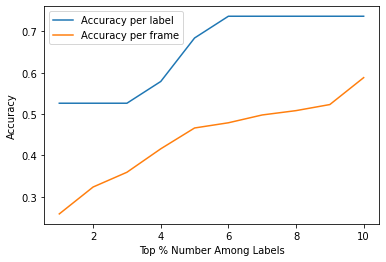

In [ ]:
import matplotlib.pyplot as plt

def test(network):
  xLabel = []
  xTotal = []
  for top in range(1, 10+1):
    network.eval()
    
    test_loss = 0
    correct = correctTotal = 0
    allLabels = collections.defaultdict(list)
    for data, target in test_loader:
        #data, target = Variable(data, volatile=True), Variable(target)
        output = network(data)

        #test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        #test_loss += F.cross_entropy(output, target, sum=True).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability

        output = output.tolist()
        target = target.tolist()
        poss_top = [[i.index(j) for j in sorted(i, reverse=True)[:top]] for i in output]
        #correctTotal += pred.eq(target.double().data.view_as(pred.double())).cpu().sum()

        pred = pred.tolist()
        for i in range(len(target)):
          label = int(target[i])
          if label in poss_top[i]:
            correctTotal += 1
          allLabels[label].extend(poss_top[i])

    #test_loss /= len(train_loader.dataset)
    
    for label in allLabels:
      most_common_labels = [i[0] for i in collections.Counter(allLabels[label]).most_common()]
      #print(collections.Counter(allLabels[label]).most_common(), label)
      #print(most_common_labels)
      if label in most_common_labels:
        correct += 1
    print(f"Top {top}:")
    print(f'  Label Accuracy: {correct}/{len(allLabels.keys())} ({correct / len(allLabels)}%)')
    print(f'  Total Accuracy: {correctTotal}/{len(test_loader.dataset)} ({correctTotal / len(test_loader.dataset)}%)')
    xLabel.append(correct / len(allLabels))
    xTotal.append(correctTotal / len(test_loader.dataset))



  plt.plot([i for i in range(1, 11)], xLabel, label='Accuracy per label')
  plt.plot([i for i in range(1, 11)], xTotal, label='Accuracy per frame')
  plt.xlabel("Top % Number Among Labels", )
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
  
test(network)